In [3]:

import googlemaps
from collections import defaultdict as dd
from datetime import datetime
from progiter import ProgIter as prog
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.path
import geojson

with open("api_key", "r") as file:
    api_key = file.read()
gmspy = googlemaps.Client(key=api_key)


class Loc(object):
    def __init__(self, name, short, lng=None, lat=None, color=(0,0,0), **kwargs):
        self.name = name
        self.short = short
        self.color= color
        
        if lng and lat:
            self.lng = lng
            self.lat = lat
        else:
            self.find_lt()

        self.directions = {}
    
    def __str__(self):
        return self.name
            
    def find_lt(self):
        self.loc = gmspy.geocode(self.name)[0]
        print("{}: {}".format(self.name, self.loc["formatted_address"]))
        self.lng = self.loc["geometry"]["location"]["lng"]
        self.lat = self.loc["geometry"]["location"]["lat"]
    
    def get_lt(self):
        return (self.lat, self.lng)

class Faculty(Loc):
    def __init__(self, *args, students=0, **kwargs):
        self.students = students
        self.color = "rgba(50, 50, 50, 0.5)"
        self.closest = None
        super().__init__(*args, **kwargs)

## Define campus area

The campus area from the [TU Delft interactive map](https://iamap.tudelft.nl/), which consists of 3 blocks; the Science Center and the Botanical garden in the North, the main Mekelpark area including all of X Delft, and the block on the other side of Kruithuisweg. The ground area of the Haagse Hogeschool and InHolland are added. While they are no part of TU Delft, they are definitely a part of the Delft campus.

In [6]:
TU_coordinates = [
    [
        (52.009215808679734, 4.3714610472668225),
        (52.009179486824024, 4.371203555201393),
        (52.00925213050599, 4.371053351496559),
        (52.00925213050599, 4.3701628581036145),
        (52.00904080310374, 4.369792713259559),
        (52.0091988974032, 4.369306339837382),
        (52.0087894491679, 4.368914737321208),
        (52.00861151594429, 4.368878602981567),
        (52.00774233917588, 4.369692577935527),
        (52.00719749030511, 4.3679491420758465),
        (52.00657998689915, 4.368485169186185),
        (52.00738240945336, 4.371430234684537),
        (52.00793610492009, 4.371559131452316),
    ],
    [
        (52.00692702678496, 4.371373836019519),
        (52.00524405881064, 4.369110266272638),
        (52.00508923149173, 4.368884960715387),
        (52.00360586726592, 4.367422450397216),
        (52.00328883579353, 4.368143964622222),
        (52.00246411937603, 4.368777146099552),
        (52.002044337192906, 4.36716677342786),
        (52.00093068281958, 4.367833591203016),
        (52.00119877409238, 4.36886087725572),
        (52.000673705375846, 4.369232378168113),
        (52.00036986368986, 4.368129990262992),
        (51.99765359355825, 4.369554127571034),
        (51.99778900973732, 4.370627011176991),
        (51.99592617562839, 4.371925200340199),
        (51.995618400031745, 4.370832099597717),
        (51.994161758285166, 4.3717869660070185),
        (51.99424763870505, 4.372178568523193),
        (51.99388760045785, 4.372468247096801),
        (51.99375217247797, 4.372044458072448),
        (51.99332606713748, 4.372301950137878),
        (51.99389420669031, 4.374479903857971),
        (51.99375259082111, 4.375833120098553),
        (51.99420181376148, 4.37790914987608),
        (51.994277784842595, 4.3786011598019225),
        (51.99506721583868, 4.381379928341351),
        (51.99757978141475, 4.379782073868097),
        (52.00070771102691, 4.37747864407855),
        (52.0032872142177, 4.376173567365091),
        (52.00231629132921, 4.372128796170633),
        (52.00458834996182, 4.3704658265814),
        (52.00628241164349, 4.372681331227701),
    ],
    [
        (51.99291817085045, 4.383368104557852),
        (51.98936680416617, 4.385850000404372),
        (51.98798148495472, 4.3807143812327265),
        (51.988873435154964, 4.380102837577331),
        (51.98829862483901, 4.377881968513),
        (51.98864879751895, 4.377586925521362),
        (51.98831844600721, 4.3762941007761835),
        (51.990670889691806, 4.3746942248659515),
    ]
]
_stations = [
    ["SD",   "Station Delft",           (239,71,111)],
    ["DC",   "Delft Campus Station",    (6,214,160)]
]
stations = {short: Loc(name, short, color=color) for short, name, color in _stations}

Station Delft: Station Delft, 2611 AC Delft, Netherlands
Delft Campus Station: Delft Campus, 2623 AX Delft, Netherlands


## Get points

Populate the campus area polygons with points. Each point will be used to find the transportation time from the point to both stations. 

In [15]:
lats, lngs = list(map(list, zip(*[cor for polygon in TU_coordinates for cor in polygon])))
ypts, xpts = 60, 40
y, x = np.meshgrid(np.linspace(min(lats), max(lats), ypts), np.linspace(min(lngs), max(lngs), xpts)) 
y, x = y.flatten(), x.flatten()
points = np.vstack((y, x)).T 

paths = [matplotlib.path.Path(coordinates) for coordinates in TU_coordinates]
grids = [path.contains_points(points) for path in paths]
search_pts = [(round(lat, 6), round(lng, 6)) for grid in grids for lat, lng, in_region in zip(y, x, grid) if in_region ]

print("search region contains {} points.".format(len(search_pts)))

search region contains 751 points.


## Find transportation time

In [19]:

modes = ["bicycling", "walking", "transit", "driving"]
now = datetime.now()
distribution = {}

for mode in modes:
    print(f"finding times for mode: {mode}")

    # Get travel times
    pt_closest = []
    pt_array = []
    for grid in grids:
        for lat, lng, in_region in prog(zip(y, x, grid)):
            if in_region:
                times = dd(int)
                try: 
                    for station in stations.values():
                        directions = gmspy.directions(
                            (lat, lng),
                            (station.lat, station.lng),
                            mode=mode,
                            departure_time=now
                        )
                        times[station.short] = sum(
                            leg["duration"]["value"]
                            for leg in directions[0]["legs"]
                        )
                    short = min(times, key=times.get)
                    pt_closest.append(short)
                    pt_array.append(short)
                except:
                    continue
            else:
                pt_array.append(None)

    # Find closest
    sd_locs = [pt for pt, station in zip(search_pts, pt_closest) if station == "SD"]
    dc_locs = [pt for pt, station in zip(search_pts, pt_closest) if station == "DC"]
    if len(sd_locs) > len(dc_locs):
        name = stations["SD"].name
        per = round(len(sd_locs)/len(search_pts)*100)
        distribution[mode] = {"SD": per, "DC": 100-per}
    else:
        name = stations["DC"].name
        per = round(len(dc_locs)/len(search_pts)*100)
        distribution[mode] = {"DC": per, "SD": 100-per}
    print(f"Mode [{mode}]: {name} with {per}%")

    # Save to geojson
    features = []
    features += [geojson.Feature(
        geometry=geojson.Point((loc[1], loc[0])),
        properties={"station": "Station Delft"}) for loc in sd_locs
    ]
    features += [geojson.Feature(
        geometry=geojson.Point((loc[1], loc[0])), 
        properties={"station": "Delft Campus"}) for loc in dc_locs
    ]
    feature_collection = geojson.FeatureCollection(features)
    with open('points_driving.geojson', 'w') as f:
        geojson.dump(feature_collection, f)

finding times for mode: transit
 2400/?... rate=339.06 Hz, total=0:00:07, wall=11:09 CET
 2400/?... rate=40.28 Hz, total=0:02:06, wall=11:11 CET
 2400/?... rate=62.49 Hz, total=0:00:38, wall=11:12 CET
Mode [transit]: Station Delft with 94%
finding times for mode: driving
 2400/?... rate=390.19 Hz, total=0:00:06, wall=11:12 CET
 2400/?... rate=32.36 Hz, total=0:01:14, wall=11:13 CET
 2400/?... rate=113.97 Hz, total=0:00:21, wall=11:13 CET
Mode [driving]: Delft Campus Station with 92%


Plot distributions

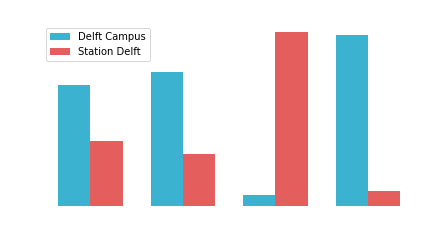

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = modes
X = [i for i in range(len(distribution))]
width = 0.35

fig, ax = plt.subplots()
dc_rects = ax.bar(
    [x - width/2 for x in X],
    [distribution[label]["DC"] for label in labels],
    width, 
    color = '#3BB2D0',
    label="Delft Campus"
)
dc_rects = ax.bar(
    [x + width/2 for x in X],
    [distribution[label]["SD"] for label in labels],
    width,
    color = "#E55E5E",
    label="Station Delft"
)

ax.set_ylabel("Percentage")
ax.set_title("Distribution of travel times")
ax.set_xticks(X)
ax.set_xticklabels(labels)
ax.legend()
ax.set_aspect(0.02)
fig.tight_layout()
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w') 
# ax.spines['right'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')
# ax.yaxis.label.set_color('w')
# ax.xaxis.label.set_color('w')
# ax.title.set_color('w')
fig.savefig("mpl_distribution.png", dpi=300, transparent=True)

## Faculties


In [4]:
_faculties = [
    ["AS(old)", 1186,   "Vereniging voor Technische Physica (VvTP), Delft"],
    ["EEMCS",   4024,   "W.I.S.V. 'Christiaan Huygens', Delft"],
    ["CEG",     3644,   "Het Gezelschap 'Practische Studie', Delft"],
    ["AE",      2642,   "VSV 'Leonardo da Vinci', Delft"],
    ["AS(new)", 1958,   "Technologisch Gezelschap, Delft"],
    ["3ME",     4866,   "Scheepsbouwkundig Gezelschap 'William Froude', Delft"],
    ["IDE",     1964,   "ID (Studievereniging ID), Delft"],
    ["IH",      1236,   "Inholland Delft"],
    ["HH",      2658,   "Studentenvereniging Nova, Delft"],
    ["BK",      2806,   "D.B.S.G. Stylos, Delft"],
    ["TPM",     1613,   "S.V.T.B. Curius, Delft"]
]
faculties = {short: Faculty(name, short, students=students) for short, students, name in _faculties}

Vereniging voor Technische Physica (VvTP), Delft: Lorentzweg 1, a109, 2628 CJ Delft, Netherlands
W.I.S.V. 'Christiaan Huygens', Delft: Mekelweg 4, 2628 CD Delft, Netherlands
Het Gezelschap 'Practische Studie', Delft: Stevinweg 1-K1.65, 2628 CN Delft, Netherlands
VSV 'Leonardo da Vinci', Delft: Kluyverweg 1, 2629 HS Delft, Netherlands
Technologisch Gezelschap, Delft: Van der Maasweg 9 (C0.050, 2629 HZ Delft, Netherlands
Scheepsbouwkundig Gezelschap 'William Froude', Delft: Mekelweg 2, 2628 CD Delft, Netherlands
ID (Studievereniging ID), Delft: Landbergstraat 15, 2628 CE Delft, Netherlands
Inholland Delft: Rotterdamseweg 141, 2628 AL Delft, Netherlands
Studentenvereniging Nova, Delft: Rotterdamseweg 137, 2628 AL Delft, Netherlands
D.B.S.G. Stylos, Delft: Julianalaan 132, 2628 BL Delft, Netherlands
S.V.T.B. Curius, Delft: Jaffalaan 5, 2628 BX Delft, Netherlands


In [8]:
tot_students = sum([sd for _, sd, _ in _faculties])
modes = ["bicycling", "walking", "transit", "driving"]
now = datetime.now()
fac_dis = {}

for mode in modes:
    print(f"finding times for mode: {mode}")

    # Find travel times
    station_students = dd(int)
    for faculty in faculties.values():
        times = dd(int)
        for station in stations.values():
            directions = gmspy.directions(
                faculty.name,
                station.name,
                mode=mode,
                departure_time=now
            )
            faculty.directions[station.short] = directions
            times[station.short] = sum(
                leg["duration"]["value"] for leg in directions[0]["legs"]
            )
        closest = min(times, key=times.get)
        faculty.closest = stations[closest]
        station_students[closest] += faculty.students

    # Get winner
    winner = max(station_students, key=station_students.get)
    loser = min(station_students, key=station_students.get)
    fac_dis[mode] = {
        winner: station_students[winner],
        loser: station_students[loser]
    }
    per = round(station_students[winner]/tot_students*100)
    print(f"Mode {mode}: {winner} with {per}%")

    # Save to geojson
    features = []
    for short, students, name in _faculties:
        faculty = faculties[short]
        point = geojson.Point((faculty.lng, faculty.lat))
        properties = {"radius": students, "station": faculty.closest.name, "html": f"{faculty.short}: {faculty.students} students"}
        features.append(geojson.Feature(geometry=point, properties=properties))
    feature_collection = geojson.FeatureCollection(features)
    with open(f'faculties_{mode}.geojson', 'w') as f:
        geojson.dump(feature_collection, f)


finding times for mode: bicycling
Mode bicycling: SD with 57%
finding times for mode: walking
Mode walking: SD with 57%
finding times for mode: transit
Mode transit: SD with 91%
finding times for mode: driving
Mode driving: DC with 90%


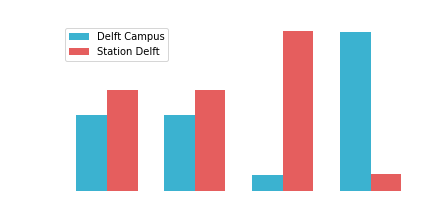

In [78]:
labels = modes
X = [i for i in range(len(fac_dis))]
width = 0.35

fig, ax = plt.subplots()
dc_rects = ax.bar(
    [x - width/2 for x in X],
    [fac_dis[label]["DC"] for label in labels],
    width, 
    color = '#3BB2D0',
    label="Delft Campus"
)
dc_rects = ax.bar(
    [x + width/2 for x in X],
    [fac_dis[label]["SD"] for label in labels],
    width,
    color = "#E55E5E",
    label="Station Delft"
)

ax.set_ylabel("Students")
ax.set_title("Distribution of closest station from faculties")
ax.set_xticks(X)
ax.set_xticklabels(labels)
ax.legend()
ax.set_aspect(0.00007)
fig.tight_layout()
# ax.spines['bottom'].set_color('w')
# ax.spines['top'].set_color('w') 
# ax.spines['right'].set_color('w')
# ax.spines['left'].set_color('w')
# ax.tick_params(axis='x', colors='w')
# ax.tick_params(axis='y', colors='w')
# ax.yaxis.label.set_color('w')
# ax.xaxis.label.set_color('w')
# ax.title.set_color('w')
fig.savefig("mpl_faculties.png", dpi=300, transparent=True)

## Interactive plots with `gmaps`.

In [ ]:
# Gmaps plotting

import gmaps
from IPython.display import display
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html

with open("api_key", "r") as file:
    api_key = file.read()
gmaps.configure(api_key=api_key)

def get_circle(loc, radius, **kwargs):
    loc.plot = gmaps.Circle(
        radius=radius,
        center=(loc.lat, loc.lng),
        **kwargs
    )
    return loc.plot

def get_colored_circle(*args, color, fill_opacity=0.1, stroke_opacity=1, **kwargs):
    return get_circle(
        *args,
        fill_color=color,
        fill_opacity=fill_opacity,
        stroke_color=color,
        stroke_opacity=stroke_opacity
    )

def get_faculty_cicles(faculties, norm=20, **kwargs):
    objs = []
    for faculty in faculties.values():
        radius = faculty.students/norm
        if faculty.closest:
            objs.append(get_colored_circle(faculty, radius, color=faculty.closest.color))
        else:
            objs.append(get_circle(faculty, radius))
    return objs

def map_style(fig):
    with open("silver.json", "r") as file:
        style = file.read()
    fig.styles = style
        
def add_layer(fig, features):
    fig.add_layer(gmaps.drawing_layer(features=features, show_controls=False))

In [ ]:
# Tu Polygons

TU_polygons = [gmaps.Polygon(cd, fill_color=(0,166,214), stroke_color=(0,166,214), fill_opacity=0.1) for cd in TU_coordinates]
NS_circles = [get_colored_circle(station, 50, color=station.color, fill_opacity=1) for station in stations.values()]

fig = gmaps.figure(center=(51.998487, 4.374864), zoom_level=15)
map_style(fig)
add_layer(fig, TU_polygons)
add_layer(fig, NS_circles)
embed_minimal_html('export/base_map.html', views=[fig])
fig

In [ ]:
# Search points

search_symbols = gmaps.symbol_layer(search_pts, fill_color=(255, 209, 102), stroke_color=(255, 209, 102), scale=1)

fig = gmaps.figure(center=(51.998487, 4.374864), zoom_level=15)
map_style(fig)
add_layer(fig, TU_polygons)
add_layer(fig, NS_circles)
fig.add_layer(search_symbols)
fig

In [ ]:
# Plot points with closest station

sd_symbols = gmaps.symbol_layer(sd_locs, fill_color=stations["SD"].color, stroke_color=stations["SD"].color, scale=1)
dc_symbols = gmaps.symbol_layer(dc_locs, fill_color=stations["DC"].color, stroke_color=stations["DC"].color, scale=1)

fig = gmaps.figure(center=(51.998487, 4.374864), zoom_level=15)
map_style(fig)
add_layer(fig, TU_polygons)
add_layer(fig, NS_circles)
fig.add_layer(sd_symbols)
fig.add_layer(dc_symbols)

fig

In [ ]:
# Plot departments

fig = gmaps.figure(center=(51.998487, 4.374864), zoom_level=15)
map_style(fig)
add_layer(fig, TU_polygons)
add_layer(fig, NS_circles)
add_layer(fig, get_faculty_cicles(faculties))
fig

In [ ]:
# Plot departments with colors

fig2 = gmaps.figure(center=(51.998487, 4.374864), zoom_level=15)
map_style(fig2)
add_layer(fig2, TU_polygons)
add_layer(fig2, NS_circles)
add_layer(fig2, get_faculty_cicles(faculties))
fig2